## High dimensional Integration 

In [2]:
# setup the environment
import nengo
import numpy as np
import scipy.special as sp
import matplotlib.pyplot as plt
import scipy.stats as st
from nengo.spa import Vocabulary
from nengo.dists import UniformHypersphere
from nengo.dists import Choice
% matplotlib inline

### Computational implementation of empirical bayes

alpha_hat:  97


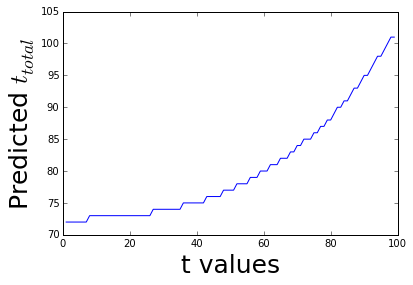

In [3]:
# assuming that maximum possible age is 120 yrs
max_age = 120


# observed values of current ages (i.e., t value)
# Here I am assuming that these are current ages of multiple people
# The goal is to estimate a prior distribution based on these ages
x_vector = [35, 5, 20, 55, 65, 72]


# all possible values of t_total (from 1 to 120)
thetas = np.linspace(start=1, stop=max_age, num=max_age)   # all possible values of theta (from 1 to 120)

# likelihood function given the set of observations x1, x2, x3, x4, x5
# Since these are iid observations, likelihood is just the product of all
def cal_likelihood(x):
    like = np.asarray([1/p for p in thetas])   #  p(X/theta)
    like[0:x-1] = [0]*np.asarray(x-1)          # likelihood is 1/theta for theta >= x and 0 otherwise
    return like

likelihood = np.ones(max_age)
for i in x_vector:
    likelihood = np.multiply(likelihood, cal_likelihood(i))    
     

# declare a matrix which will store p_theta along columns for each given alpha
# theta varies along rows, and alpha varies along columns
p_matrix = np.zeros((len(thetas), max_age))
for x in np.arange(1,max_age+1,1):
    p_theta = [(st.skewnorm.pdf(p, a=-4, loc=x, scale=28)) for p in thetas]
    p_theta = p_theta/np.sum(p_theta)    # normalize prior (to sum up to 1)
    p_matrix[:, x-1] = p_theta
    

# Now compute p(X/alpha) by marginalizing out theta for each alpha
marginpost_set = np.dot(likelihood, p_matrix)   # this will be a list of dimentions (1 x max_age)
#pick the max value and find the corresponding alpha
alpha_hat = np.argmax(marginpost_set) + 1

print "alpha_hat: ", alpha_hat

# p(theta/alpha_hat): Note that I am considering loc parameter to be alpha (unknown)
# Assuming that a and scale parameters are known
p_theta_ga = [(st.skewnorm.pdf(p, a=-4, loc=alpha_hat, scale=28)) for p in thetas]
p_x = np.sum(np.multiply(p_theta_ga, likelihood)) 
posterior = np.multiply(p_theta_ga, likelihood) / p_x

def median(posterior):
    median = 0
    for a in np.arange(len(posterior)):
        cum = sum(posterior[:a+1])
        if cum == 0.5 or cum > 0.5:
            median = a + 1
            break
    return median

predictions = []
for x in np.arange(1,100,1):
    like = [1/p for p in thetas]  #  p(X/theta)
    like[0:x-1] = [0]*(x-1)  # likelihood is 1/theta for theta >= x and 0 otherwise
    p_x = np.sum(np.multiply(p_theta_ga, like))       # already sums to 1
    posterior = np.multiply(p_theta_ga, like) / p_x   # already sums to 1
    prediction = median(posterior)
    predictions.append(prediction)
    
plt.figure()
plt.plot(np.arange(1,100,1), predictions)
plt.xlabel("t values", fontsize=25)
plt.ylabel("Predicted $t_{total}$", fontsize=25)
plt.show()

In [4]:
holder = np.zeros((1,len(likelihood)))    # change shape of likelihood from (120,) to (1,120)
holder[0,:] = likelihood
likelihood = holder

print likelihood.shape
print p_matrix.shape

(1, 120)
(120, 120)


### Nengo Model of empirical bayes
This implementation is focused on computing the hyperparameter $\hat{\alpha}$ in order to compute the prior. Once we have the prior, we can use the same approach as outlined in the Nengo Model outlined in the previous notebook (titled 780(1) - Representation and Nengo Model). 

Note: Since the prior was a skewed gaussian, I have assumed that $\alpha$ is the mean of the gaussian and all other parameters (i.e., variance and the skew parameter) are known.

In [5]:
# Now represent the likelihood i.e., P(X/theta) and P(theta/alpha) in neurons
# And then compute P(X/alpha) by marginalizing out theta for each alpha

num_neurons = 50
dim = max_age

# Values should stay within the range (-radius,radius)
radius = 1

rng = np.random.RandomState(12) 
num_samples = 4000

model = nengo.Network(seed=123)
with model:  
    
    # define eval points to only represent positive values
    encoders = UniformHypersphere(surface=True).sample(num_neurons, 1, rng=rng)
    eval_points = rng.uniform(0, 1, size=(num_samples, 1))
    
    # Make 2 EnsembleArrays to store the input
    lik = nengo.networks.EnsembleArray(n_neurons=num_neurons, n_ensembles=likelihood.size, 
                                radius=radius, encoders=encoders, eval_points=eval_points, 
                                n_eval_points=eval_points.shape[0])
    prior = nengo.networks.EnsembleArray(n_neurons=num_neurons, n_ensembles=p_matrix.size, 
                                radius=radius, encoders=encoders, eval_points=eval_points, 
                                n_eval_points=eval_points.shape[0])
    
    # connect inputs to them so we can set their value
    likelihood_in = nengo.Node(output=likelihood.ravel())    # p(X/theta): matrix of dimension (1, 120)
    prior_in = nengo.Node(output=p_matrix.ravel())   # p(theta/alpha): matrix of dimension (120, 120)
    nengo.Connection(likelihood_in, lik.input)
    nengo.Connection(prior_in, prior.input)
    
   
    
    # The C matix is composed of populations that each contain
    # one element of 'lik' and one element of 'prior'.
    # These elements will be multiplied together in the next step.
    
    # The appropriate encoders make the multiplication more accurate
    #eval_points = rng.uniform(0, 1, size=(50, 2))
    C = nengo.networks.EnsembleArray(n_neurons=num_neurons,
                                     n_ensembles=likelihood.size * p_matrix.shape[1],
                                     ens_dimensions=2,
                                     radius=1.5 * radius,
                                     encoders=Choice([[1, 1], [-1, 1], [1, -1], [-1, -1]]))
                                     
    # Now compute the products and do the appropriate summing
    #eval_points = rng.uniform(0, 1, size=(50, 1))
    D = nengo.networks.EnsembleArray(n_neurons=num_neurons,
                                     n_ensembles=likelihood.shape[0] * p_matrix.shape[1],
                                     radius=radius)

                                     

In [6]:
# Determine the transformation matrices to get the correct pairwise products computed.

transformA = np.zeros((C.dimensions, likelihood.size))
transformB = np.zeros((C.dimensions, p_matrix.size))

for i in range(likelihood.shape[0]):
    for j in range(likelihood.shape[1]):
        for k in range(p_matrix.shape[1]):
            tmp = (j + k * likelihood.shape[1] + i * p_matrix.size)
            transformA[tmp * 2][j + i * likelihood.shape[1]] = 1
            transformB[tmp * 2 + 1][k + j * p_matrix.shape[1]] = 1
            
print("Likelihood->C")
print(transformA)
print("p_matrix->C")
print(transformB)


def product(x):
    return x[0] * x[1]

# The mapping for this transformation (C->D) is much easier, since we want to
# combine D2 pairs of elements (we sum D2 products together)
transformC = np.zeros((D.dimensions, p_matrix.size))
for i in range(p_matrix.size):
    transformC[i // p_matrix.shape[0]][i] = 1
print("C->D")
print(transformC)

Likelihood->C
[[ 1.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  1.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  1.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
p_matrix->C
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  1.]]
C->D
[[ 1.  1.  1. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  1.  1.  1.]]


In [7]:
with model:
    nengo.Connection(lik.output, C.input, transform=transformA)
    nengo.Connection(prior.output, C.input, transform=transformB)
    
    prod = C.add_output("product", product)
    nengo.Connection(prod, D.input, transform=transformC)
    

In [8]:
with model:
    # probes
    lik_p = nengo.Probe(lik.output, sample_every=0.01, synapse=0.01)
    prior_p = nengo.Probe(prior.output, sample_every=0.01, synapse=0.01)
    C_probe = nengo.Probe(C.output, sample_every=0.01, synapse=0.01)
    D_probe = nengo.Probe(D.output, sample_every=0.01, synapse=0.01)


In [9]:
sim = nengo.Simulator(model)  # Create the simulator
sim.run(0.2)

Building finished in 0:05:05.                                                   
Simulating finished in 0:08:52.                                                 


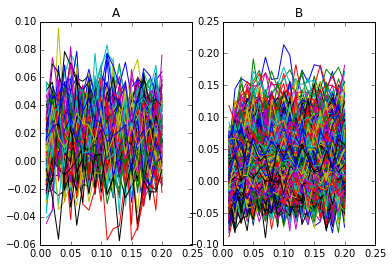

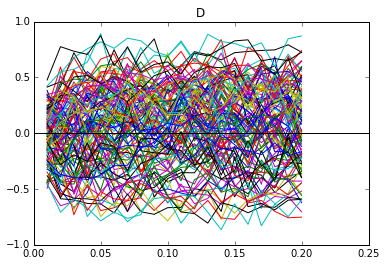

In [11]:
plt.subplot(1, 2, 1)
plt.title('A')
plt.plot(sim.trange(dt=0.01), sim.data[lik_p])
plt.subplot(1, 2, 2)
plt.title('B')
plt.plot(sim.trange(dt=0.01), sim.data[prior_p]);

plt.figure()
plt.plot(sim.trange(dt=0.01), sim.data[D_probe])
for d in np.dot(likelihood, p_matrix).flatten():
    plt.axhline(d, color='k')
plt.title("D");

Note that the result of the multiplication doesn't make sense for this case and I found in the following cell that the reason might be the wide range of p_matrix due to which its representation might not be accurate.

In [14]:
D = sim.data[D_probe]
arr = D[len(D)-1]
print "alpha hat: ", np.argmax(arr)

#print likelihood
#print p_matrix
#print np.max(likelihood)
#print np.min(likelihood)

print "Max value in p_matrix: " , np.max(p_matrix)
print "Min value in p_matrix: " , np.min(p_matrix)

alpha hat:  87
Max value in p_matrix:  0.167153812128
Min value in p_matrix:  1.64188518781e-69


In [ ]:
from nengo_gui.ipython import IPythonViz
IPythonViz(model, "empirical_bayes_version.py.cfg")

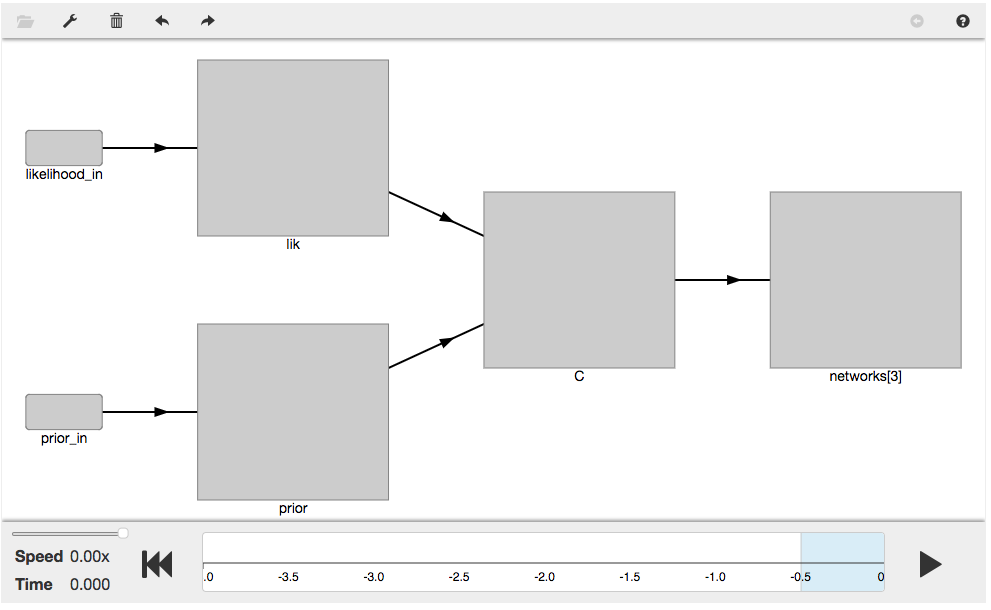

In [16]:
from IPython.display import Image
Image(filename='matrix_mul_net.png')